# Práctica 2: Clasificador de tweets
## por Federico Pardo García

## Máster en BIG DATA: Tecnologías de Gestión de Información No Estructurada 2020/2021


## Introducción
¿Empezamos?

In [1]:
import twitter
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import PredefinedSplit
import pandas as pd
import os.path

SEED_VALUE = 1234

api = twitter.Api(consumer_key='vJx3WkjUjATxveo8NK3tsVniM',
                  consumer_secret='DLuw7WXYXwLIAVG2GtQHcVjOWM8Mq5a1qn3ZynniQSbSfKWSvM',
                  access_token_key='769542991832907780-yM58uOw32rNLJe0OD3EBmD5KwdsScwv',
                  access_token_secret='wBAtr8mhrOBQZE1ccv1y3tSAO8om2afmodatnj8gKLswn',
                  sleep_on_rate_limit=True, # Nos permite despreocuparnos de rate_limits
                  tweet_mode='extended')


In [2]:
def get_tweets(first_200, screen_name, last_id):
    all_tweets = []
    all_tweets.extend(first_200)
    for i in range(5000):
        new = api.GetUserTimeline(screen_name=screen_name, max_id = last_id-1)
        if len(new) > 0:
            all_tweets.extend(new)
            last_id = new[-1].id
        else:
            break
    return all_tweets

def dump_XML(tweets, name):
    items = ET.Element("data")
    for tweet in tweets:
        element = ET.SubElement(items, 'tweet')
        element.set('id', str(tweet.id))
        element.set('user_id', str(tweet.user.id))
        element.set('user_name', tweet.user.screen_name)
        element.set('date', str(tweet.created_at_in_seconds))
        element.text = tweet.full_text + '\n'
            

    mydata = ET.ElementTree(items)
    mydata.write("./extracted_users/" + name + ".xml")
    
    
def extract_XML(filename):
    tree = ET.ElementTree(file = "./extracted_users/" + filename)
    root = tree.getroot()
    collection = []
    for doc in root:
        collection.append(doc.text)
    return collection
    
def timeline(name):
    first200 = api.GetUserTimeline(screen_name=name, count=200)
    all_tweets = get_tweets(first200, name, first200[-1].id)
    dump_XML(all_tweets, name)

In [3]:
# Introducimos los nombres de usuario
users = ['GeorgeRussell63','LandoNorris', 'BillGates']
for user in users:
    if not os.path.exists("./extracted_users/"+user+".xml"):
        timeline(user)

## Clasificación de personalidades similares

### Dividimos en 70% train y 30% test

In [4]:
def split_TrainTest(vectorizedDS, corpus1_len, corpus2_len):
    '''
    Dado el vector de un corpus y las longitudes de los corpus que lo componen,
    lo separará en train y test con sus correspondientes etiquetas.
    '''
    
    # Separamos el data frame según el autor del tweet
    corpus1vectorized = vectorizedDS[:corpus1_len]
    corpus2vectorized = vectorizedDS[corpus2_len:]
    
    # Punto de corte para cada autor (70%)
    nCorpus1 = int(corpus1_len*0.7)
    nCorpus2 = int(corpus2_len*0.7)
    print(nCorpus1+nCorpus2)
    print(corpus1_len+corpus2_len)
    
    # Predictores de entrenamiento (usamos los más antiguos)
    x1train = corpus1vectorized[-nCorpus1:]
    x2train = corpus2vectorized[-nCorpus2:]
    frames = [x1train,x2train]
    xTrain = pd.concat(frames)

    # Predictores de test (usamos los más modernos)
    x1test = corpus1vectorized[:corpus1_len-nCorpus1]
    x2test = corpus2vectorized[:corpus2_len-nCorpus2]
    frames = [x1test,x2test]
    xTest = pd.concat(frames)
    
    # Salida de entrenamiento
    y1train = (np.zeros((nCorpus1, 1))).tolist()
    y2train = (np.ones((nCorpus2, 1))).tolist()
    y1train.extend(y2train)
    yTrain = y1train
    
    # Salida de test
    y1test = (np.zeros((corpus1_len-nCorpus1, 1))).tolist()
    y2test = (np.ones((corpus2_len-nCorpus2, 1))).tolist()
    y1test.extend(y2test)
    yTest = y1test
    
    return (xTrain, yTrain, xTest, yTest)

In [5]:
def get_bag_of_words(corpus):
    '''
    Devuelve una representación "bag of words" para un corpus de documentos.
    '''
    english_stop_words = text.ENGLISH_STOP_WORDS
    vectorizer = CountVectorizer(stop_words = english_stop_words, min_df=20)
    corpusVectorized = vectorizer.fit_transform(corpus)
    df_tf = pd.DataFrame(corpusVectorized.todense(), columns=vectorizer.get_feature_names())
    return df_tf

In [6]:
russell = extract_XML('GeorgeRussell63.xml')
norris = extract_XML('LandoNorris.xml')
corpus = russell + norris

df_tf = get_bag_of_words(corpus)
(xTrain, yTrain, xTest, yTest) = split_TrainTest(df_tf, len(russell), len(norris))
print(xTrain.shape, len(yTrain))
yTrain = pd.DataFrame(yTrain).values.ravel()
yTest = pd.DataFrame(yTest).values.ravel()

4036
5767
(4036, 378) 4036


### Entrenamiento con SVC

In [7]:
clf = SVC()
hyperparameters ={'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                 'C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
                 'random_state':[SEED_VALUE]}
modelCV = GridSearchCV(clf,
                       hyperparameters,
                       cv=5,
                       scoring='precision',
                       verbose=True,
                       n_jobs=-1,
                       return_train_score=True)
np.random.seed(SEED_VALUE)
modelCV.fit(xTrain, yTrain)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  3.0min finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [1234]},
             return_train_score=True, scoring='precision', verbose=True)

Los kernels más prometedores parecen ser 'linear' y 'rbf', por lo que vamos a comparar estos dos en una gráfica.

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.001,0.588976,0.013448,28
1,poly,0.001,0.556491,0.000220,30
2,rbf,0.001,0.556491,0.000220,30
3,sigmoid,0.001,0.556491,0.000220,30
4,linear,0.01,0.755297,0.162991,23
5,poly,0.01,0.558849,0.001315,29
6,rbf,0.01,0.720896,0.101666,25
7,sigmoid,0.01,0.659805,0.083519,26
8,linear,0.1,0.783836,0.130686,14
9,poly,0.1,0.633645,0.038064,27


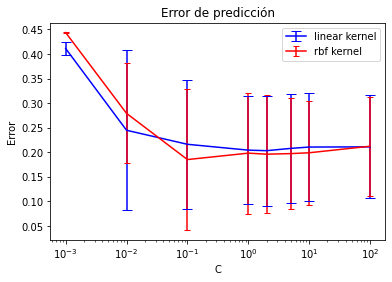

In [8]:
cv_results = pd.DataFrame(modelCV.cv_results_)
display(cv_results.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

cv_results_train_linear = cv_results.loc[cv_results['param_kernel'] =="linear"]
cv_results_train_rbf = cv_results.loc[cv_results['param_kernel'] =="rbf"]

plt.errorbar(cv_results_train_linear["param_C"],
            1-cv_results_train_linear['mean_test_score'],
            cv_results_train_linear['std_test_score'],
             color = "blue",
             label="linear kernel",
            capsize=5)
plt.errorbar(cv_results_train_rbf["param_C"],
            1-cv_results_train_rbf['mean_test_score'],
            cv_results_train_rbf['std_test_score'],
             color = "red",
             label = "rbf kernel",
            capsize=3)

plt.title("Error de predicción")
plt.xlabel("C")
plt.ylabel("Error")
plt.legend(loc='upper right')
plt.xscale('log')
plt.show()

In [9]:
split_test_fold = [-1]*len(yTrain) + [0]*len(yTest)
ps = PredefinedSplit(test_fold=split_test_fold)
x_all = np.vstack([xTrain, xTest])
y_all = np.hstack([np.array(yTrain), np.array(yTest)])

In [10]:
clf = SVC()

modelCV = GridSearchCV(clf,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy',
                       verbose=True,
                       n_jobs=8,
                       return_train_score=True)
np.random.seed(SEED_VALUE)
modelCV.fit(x_all, y_all)

Fitting 1 folds for each of 32 candidates, totalling 32 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:  1.1min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=SVC(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [1234]},
             return_train_score=True, scoring='accuracy', verbose=True)

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.001,0.593876,0.0,28
1,poly,0.001,0.556326,0.0,30
2,rbf,0.001,0.556326,0.0,30
3,sigmoid,0.001,0.556326,0.0,30
4,linear,0.01,0.621606,0.0,25
5,poly,0.01,0.556904,0.0,29
6,rbf,0.01,0.666089,0.0,15
7,sigmoid,0.01,0.618140,0.0,27
8,linear,0.1,0.660890,0.0,20
9,poly,0.1,0.621028,0.0,26


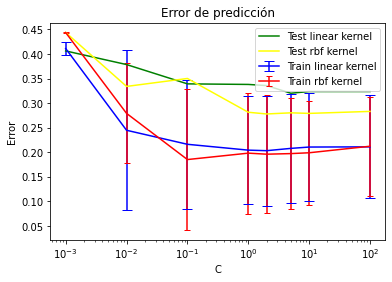

In [11]:
cv_results_test = pd.DataFrame(modelCV.cv_results_)
display(cv_results_test.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

cv_results_test_linear = cv_results_test.loc[cv_results['param_kernel'] =="linear"]
cv_results_test_rbf = cv_results_test.loc[cv_results['param_kernel'] =="rbf"]


plt.errorbar(cv_results_train_linear["param_C"],
            1-cv_results_train_linear['mean_test_score'],
            cv_results_train_linear['std_test_score'],
             color = "blue",
             label="Train linear kernel",
            capsize=5)

plt.errorbar(cv_results_train_rbf["param_C"],
            1-cv_results_train_rbf['mean_test_score'],
            cv_results_train_rbf['std_test_score'],
             color = "red",
             label = "Train rbf kernel",
            capsize=3)


plt.plot(cv_results_test_linear["param_C"],
            1-cv_results_test_linear['mean_test_score'],
             color = "green",
             label="Test linear kernel")
plt.plot(cv_results_test_rbf["param_C"],
            1-cv_results_test_rbf['mean_test_score'],
             color = "yellow",
             label = "Test rbf kernel")

plt.title("Error de predicción")
plt.xlabel("C")
plt.ylabel("Error")
plt.legend(loc='upper right')
plt.xscale('log')
plt.savefig("plot.pdf")
plt.show()

## Clasificación de personalidades diferentes

In [12]:
gates = extract_XML('BillGates.xml')
norris = extract_XML('LandoNorris.xml')
corpus = gates + norris

df_tf = get_bag_of_words(corpus)
(xTrain, yTrain, xTest, yTest) = split_TrainTest(df_tf, len(gates), len(norris))
yTrain = pd.DataFrame(yTrain).values.ravel()
yTest = pd.DataFrame(yTest).values.ravel()

4513
6448


In [13]:
clf = SVC()
hyperparameters ={'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                 'C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
                 'random_state':[SEED_VALUE]}
modelCV = GridSearchCV(clf,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       verbose=True,
                       n_jobs=8,
                       return_train_score=True)
np.random.seed(SEED_VALUE)
modelCV.fit(xTrain, yTrain)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 160 out of 160 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=8,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'random_state': [1234]},
             return_train_score=True, scoring='accuracy', verbose=True)

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.001,0.834750,0.180649,25
1,poly,0.001,0.502327,0.000414,30
2,rbf,0.001,0.502327,0.000414,30
3,sigmoid,0.001,0.458030,0.088373,32
4,linear,0.01,0.841398,0.182061,24
5,poly,0.01,0.601785,0.105149,29
6,rbf,0.01,0.803043,0.088057,27
7,sigmoid,0.01,0.834529,0.181063,26
8,linear,0.1,0.928892,0.084520,11
9,poly,0.1,0.713457,0.143880,28


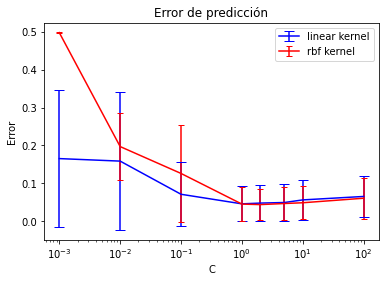

In [14]:
cv_results = pd.DataFrame(modelCV.cv_results_)
display(cv_results.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

cv_results_train_linear = cv_results.loc[cv_results['param_kernel'] =="linear"]
cv_results_train_rbf = cv_results.loc[cv_results['param_kernel'] =="rbf"]

plt.errorbar(cv_results_train_linear["param_C"],
            1-cv_results_train_linear['mean_test_score'],
            cv_results_train_linear['std_test_score'],
             color = "blue",
             label="linear kernel",
            capsize=5)
plt.errorbar(cv_results_train_rbf["param_C"],
            1-cv_results_train_rbf['mean_test_score'],
            cv_results_train_rbf['std_test_score'],
             color = "red",
             label = "rbf kernel",
            capsize=3)

plt.title("Error de predicción")
plt.xlabel("C")
plt.ylabel("Error")
plt.legend(loc='upper right')
plt.xscale('log')
plt.show()

,param_kernel,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.001,0.484755,0.0,31
1,poly,0.001,0.502326,0.0,29
2,rbf,0.001,0.502326,0.0,29
3,sigmoid,0.001,0.524548,0.0,27
4,linear,0.01,0.668217,0.0,25
5,poly,0.01,0.513695,0.0,28
6,rbf,0.01,0.786047,0.0,21
7,sigmoid,0.01,0.484755,0.0,31
8,linear,0.1,0.880103,0.0,10
9,poly,0.1,0.660465,0.0,26


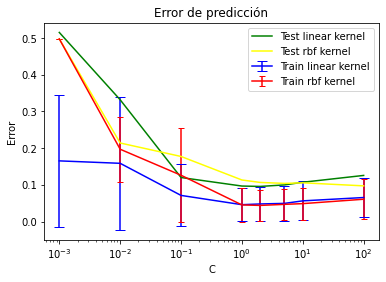

In [15]:
split_test_fold = [-1]*len(yTrain) + [0]*len(yTest)
ps = PredefinedSplit(test_fold=split_test_fold)

x_all = np.vstack([xTrain, xTest])
yTest = pd.DataFrame(yTest).values.ravel()
y_all = np.hstack([np.array(yTrain), np.array(yTest)])

clf = SVC()
modelCV = GridSearchCV(clf,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy',
                       n_jobs=8,
                       return_train_score=True)
np.random.seed(SEED_VALUE)
modelCV.fit(x_all, y_all)



cv_results_test = pd.DataFrame(modelCV.cv_results_)
display(cv_results_test.loc[:, ['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']])

cv_results_test_linear = cv_results_test.loc[cv_results['param_kernel'] =="linear"]
cv_results_test_rbf = cv_results_test.loc[cv_results['param_kernel'] =="rbf"]


plt.errorbar(cv_results_train_linear["param_C"],
            1-cv_results_train_linear['mean_test_score'],
            cv_results_train_linear['std_test_score'],
             color = "blue",
             label="Train linear kernel",
            capsize=5)

plt.errorbar(cv_results_train_rbf["param_C"],
            1-cv_results_train_rbf['mean_test_score'],
            cv_results_train_rbf['std_test_score'],
             color = "red",
             label = "Train rbf kernel",
            capsize=3)


plt.plot(cv_results_test_linear["param_C"],
            1-cv_results_test_linear['mean_test_score'],
             color = "green",
             label="Test linear kernel")
plt.plot(cv_results_test_rbf["param_C"],
            1-cv_results_test_rbf['mean_test_score'],
             color = "yellow",
             label = "Test rbf kernel")

plt.title("Error de predicción")
plt.xlabel("C")
plt.ylabel("Error")
plt.legend(loc='upper right')
plt.xscale('log')
plt.savefig("plot.pdf")
plt.show()